# AR-MA

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/04/media/cover.png?raw=1" style="width: 40%; display: block; margin: auto;">

## Содержание

1. Автокорреляционная функция (ACF).
2. Частичная автокорреляционная функция  (PACF).
3. Объяснение того, как работают модели авторегрессии и скользящего среднего.

In [2]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.holtwinters import ExponentialSmoothing

np.random.seed(0) # For reproducibility

In [3]:
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

## Корреляции во временных рядах
- Корреляционная функция измеряет степень связи между двумя случайными величинами.
- В данных временных рядов она измеряет связь между двумя различными моментами времени.
- Корреляция важна для понимания линейной зависимости в данных временных рядов.
- Существует два типа корреляционных функций:
    - Автокорреляция.
    - Взаимная корреляция.

### Автокорреляционная функция (ACF)
  - ACF измеряет корреляцию временного ряда с его собственными запаздывающими значениями
  
  $$ ACF(k) = \frac{\mathbb{E}[(X(t) - \mu)(X(t-k) - \mu)]}{\sigma^2} $$
  
  - где:
    - $k$ лаг автокорреляции.
    - $X(t)$ значение ряда в момент времени $t$.
    - $\mu$ среднее значение, вычисляемое по всему ряду.
    - $\sigma^2$ дисперсия.
  - Значения, близкие к $1$ или $-1$, указывают на сильную корреляцию, в то время как значения, близкие к $0$, указывают на слабую корреляцию.

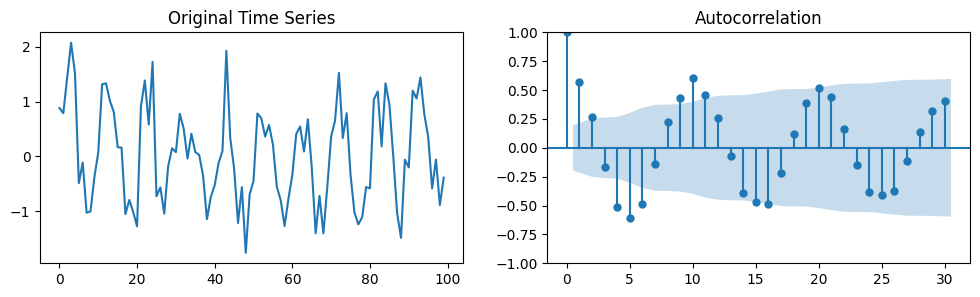

In [4]:
n = 100

time_series_1 = np.random.normal(0, 0.5, n) + np.sin(2*np.pi/10*np.arange(n))
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(time_series_1)
axes[0].set_title('Original Time Series')
# Построим первые 20 лагов. Можно построить больше, изменяя `lags` аргумент.
plot_acf(time_series_1, lags=30, alpha=0.05, ax=axes[1]);

- На правом графике изображена коррелограмма – график, визуализирующий автокорреляционную функцию. Точками на графике показаны значения автокорреляционной функции.
- Синяя область представляет доверительный интервал. Корреляции за пределами доверительного интервала являются статистически значимыми, в то время как остальные - нет. В  данном случае значени $alpha=0.05$  (доверительный интервал 95%), но его можно установить на другие уровни.
- Временной ряд хорошо коррелирует с самим собой, сдвинутым на 1 ($lag = 1$)
- Имеется также корреляция при $lag = 2$, но она не так хороша, какт при $lag = 1$. И так далее..
- Смотрите [документацию](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) для большей информации..

### Фунция взаимной корреляции  (CCF)

- CCF измеряет корреляцию между двумя временными рядами с разными значениями лага:

$$CCF(k) = \frac{E[(X(t) - \mu_x)(Y(t-k) - \mu_y)]}{\sigma_x \sigma_y}$$

- где:
  - $X$ и $Y$ два различных временных ряда.
  - $\mu_x, \mu_y$ их средние, и $\sigma_x, \sigma_y$ их стандартные отклонения.
- CCF обычно используется для поиска более короткого, известного признака в длинном сигнале.

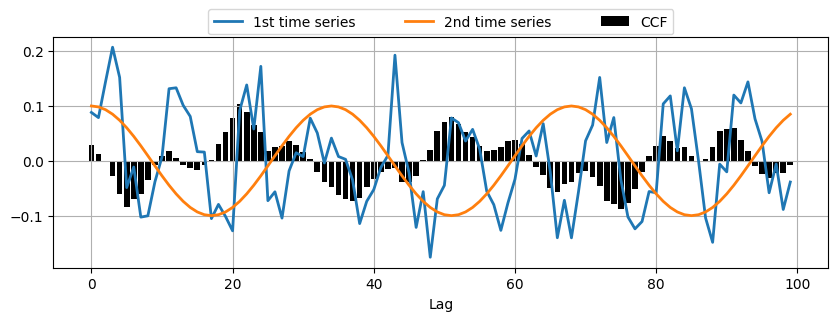

In [5]:
time_series_2 = np.cos(np.pi/17*np.arange(n))

# Calculate CCF between the two time series
ccf_vals = ccf(time_series_1, time_series_2, adjusted=False)

# Plot CCF
_, ax = plt.subplots(1,1,figsize=(10,3))
ax.bar(range(len(ccf_vals)), ccf_vals, color='k', label='CCF')
ax.plot(time_series_1*0.1, linewidth=2, label='1st time series')
ax.plot(time_series_2*0.1, linewidth=2, label='2nd time series')
plt.xlabel('Lag')
plt.legend(bbox_to_anchor=(0.2, 1.01, .6, 1.5), loc='lower center', ncol=3, mode="expand", borderaxespad=0.)
plt.grid();

### Практическое применение корреляционных функций
  - Определение характера данных (например, являются ли они случайными, имеют тренд или сезонность).
  - Помощь в определении порядка построения моделей ARIMA (подробнее об этом позже).
  - Выявление выбросов во временных рядах.

### Ограничения и соображения
1. Корреляционные функции измеряют только "линейные" связи.
2. Для получения значимых результатов временные ряды должны быть "стационарными".
3. Высокая корреляция не подразумевает "причинно-следственной связи" и иногда может вводить в заблуждение.
     
<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/04/media/timoelliot.png?raw=1" style="width: 25%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Image: <a href="https://timoelliott.com/">timoelliot</a></div>

4. ACF измеряет как прямые, так и *косвенные корреляции* между лагами.

- Сильная корреляция при более высоких лагах может быть результатом накопления корреляций при более коротких лагах.

- Рассмотрим, например, случайное блуждание:

$$X(t)=X(t-1)+\epsilon_t$$

- Вы можете подумать, что только лаг $h=1$ важен, однако...

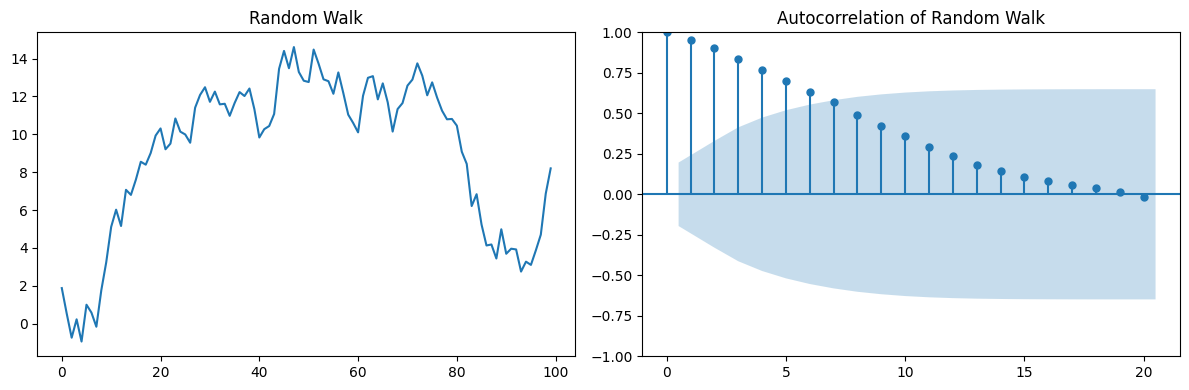

In [6]:
random_walk = np.cumsum(np.random.normal(0, 1, 100))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(random_walk)
axes[0].set_title('Random Walk')
plot_acf(random_walk, lags=20, alpha=0.05, ax=axes[1])
axes[1].set_title('Autocorrelation of Random Walk')
plt.tight_layout()

- Вы можете видеть, что лаги $h>1$ также присутствуют в ACF.
- Это косвенные корреляции из-за накопления основной корреляции при лаге $h=1$.

### Частичная автокорреляционная функция  (PACF)
- PACF устраняет 4-е ограничение ACF, выделяя прямую корреляцию между временным рядом и его версией с запаздыванием.
- Это достигается за счет устранения влияния корреляций при более коротких запаздываниях.
- Высокий PACF при лаге $k$ указывает на сильную частичную корреляцию с $k$-м лагом, не учитываемую корреляциями при меньших лагах..


- PACF с лагом $k$ иногда обозначается как $\phi_{kk}$:

$$\phi_{kk} = \text{Corr}\big(X(t) - \hat{X}(t), X(t-k) - \hat{X}(t-k)\big)$$

- где:
    - $\hat{X}(t)$ - прогнозируемое значение ряда $X(t)$ основанное на всех значениях до $t-1$.
    - $\hat{X}(t-k)$ - прогнозируемое значение ряда $X(t-k)$ основанное на всех значениях до $t-k-1$.

- Совместное использование ACF и PACF обеспечивает более полное понимание временных рядов.
- ACF помогает определить общую структуру корреляции и потенциальную сезонность.
- PACF определяет конкретные значения лагов, которые оказывают существенное влияние на текущее значение.

**Пример**

- Рассмотрим временной ряд, где ACF показывает значительную корреляцию на лагах 1, 2 и 3.
- Без PACF неясно, является ли корреляция на лаге 3 прямой или просто отражением сильных корреляций на лагах 1 и 2.
- PACF может прояснить это, показав, есть ли значимая прямая корреляция на лаге 3.

In [7]:
n = 100

time_series = np.zeros(n)
# Коэффициенты для индуцирования автокорреляции при лагах 1, 2 и 3
alpha1, alpha2, alpha3 = 0.6, -0.3, 0.2
noise = np.random.normal(0, 1, n)

# Generate correlated data
for t in range(3, n):
    time_series[t] = alpha1 * time_series[t-1] + alpha2 * time_series[t-2] + alpha3 * time_series[t-3] + noise[t]

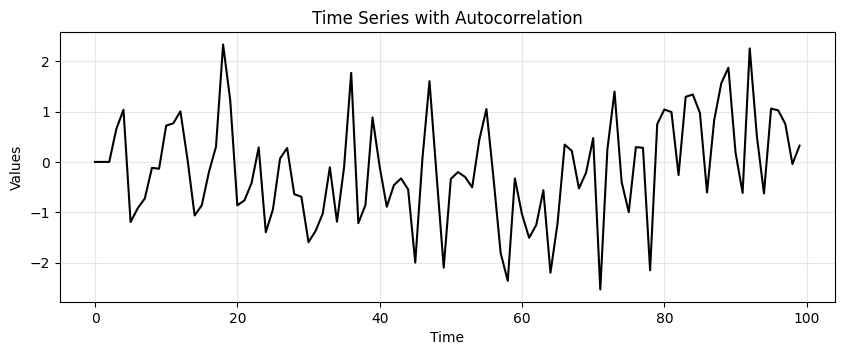

In [8]:
run_sequence_plot(np.arange(100), time_series, title='Time Series with Autocorrelation');

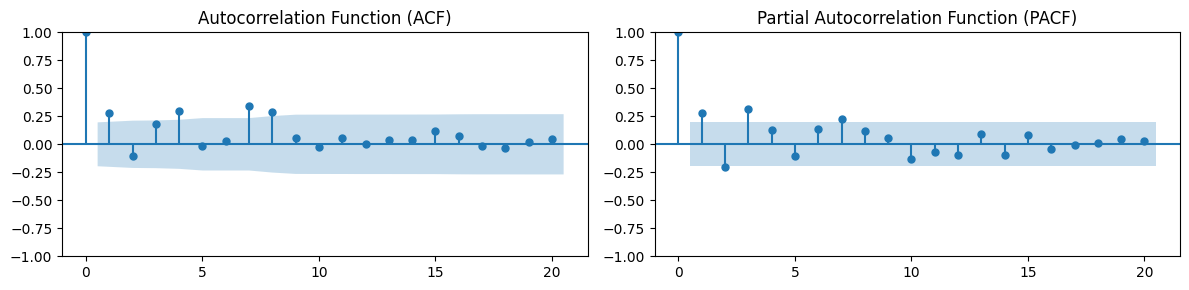

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot ACF
plot_acf(time_series, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(time_series, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()


- Оценка значения лага с помощью ACF и PACF полезна при моделировании временных рядов с помощью моделей авторегрессии и скользящего среднего, которые мы рассмотрим далее.


## Модели авторегрессии (AR)

  - Модель авторегрессии (AR model) это тип модели временного ряда, которая использует наблюдения из предыдущих временных шагов в качестве входных данных для уравнения регрессии. Эта модель использется для прогнозирования значения на следующем временном шаге.
  - AR-модель зависит только от своих собственных прошлых значений.
  

- Общая форма AR-модели порядка $p$ имеет вид:

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \dots + \phi_p X(t-p) + \epsilon_t$$

- где
    - $X(t)$: значение временного ряда в момент времени $t$.
    - $c$: константа (так назывемый "свободный коэффициент").
    - $\phi_1, \phi_2, \dots, \phi_p$: коэффициенты модели.
    - $p$: порядок AR-модели (число используемых лагов).
    - $\epsilon_t$: ошибка (белый шум) в момент времени $t$.

**Модель AR(1)**
- Модель первого порядка авторегрессии, AR(1), имеет вид:

$$X(t) = c + \phi_1 X(t-1) + \epsilon_t$$

- В модели AR(1) текущее значение основано на непосредственно предшествующем ему значении.

- Пример: простая модель цены акции, в которой сегодняшняя цена частично зависит от цены вчерашнего дня.

**Авторегрессионные модели высокого порядка**
- Авторегрессионные модели высокого порядка (AR(2), AR(3) и т. д.) зависят от более чем одного предыдущего значения.
- Например, модель AR(2) имеет вид:
  :

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \epsilon$$
- Эти модели полезны в ситуациях, когда влияние более чем одного предыдущего временного шага является значительным.t.

**Оценка коэффициентов модели AR**
- Коэффициенты моделей AR можно оценить с помощью различных методов, таких как оценка максимального правдоподобия или метод наименьших квадратов.
- Оцененные коэффициенты позволяют понять, какое влияние оказывают прошлые значения на текущее значение в временном ряду.
- Другими словами, модели AR *интерпретируемы*.

**Ограничения моделей AR**
- Для моделей AR требуется, чтобы временной ряд был *стационарным*.
- Модели AR высокого порядка могут *переобучаться* на данных обучения и плохо работать при прогнозировании.
- Они не могут моделировать нелинейные зависимости в данных.

- По своей природе модели AR не учитывают *внешние факторы*.
- Обычно это дополнительные временные ряды, которые имеют значение для прогнозирования.
- Например, временной ряд температур при прогнозировании нагрузки на электроэнергию.
- Существуют расширения (ARMAX), которые позволяют включать в модель внешние переменные.



### Определение порядка модели AR
- Как определить правильный порядок $p$ для модели AR?
- Это можно сделать, посмотрев на первые лаги частичной автокорреляционной функции (PACF)
- Давайте рассмортим это на примере..

- Сгенерируем данные с помощью AR(2) с коэффициентами `[1.0, -0.5, 0.7]`.
- Заметим, что значение `1.0` в начале ACF относится к нулевому лагу и всегда равно `1.0`.

In [10]:
ar_data = arma_generate_sample(ar=np.array([-1.5, 0.5, 0.7]), ma=np.array([1]), nsample=200, scale=1, burnin=1000)

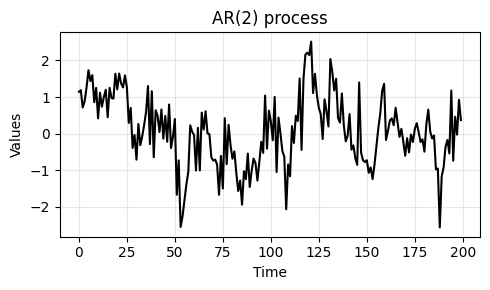

In [11]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
run_sequence_plot(np.arange(200), ar_data, ax=ax, title="AR(2) process")
plt.tight_layout()

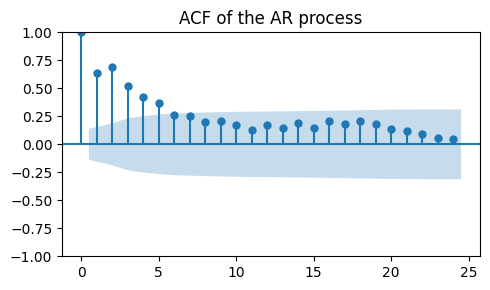

In [12]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ar_data, ax=ax, title="ACF of the AR process")
plt.tight_layout();

- Затем вычислим PACF для `ar_data`.

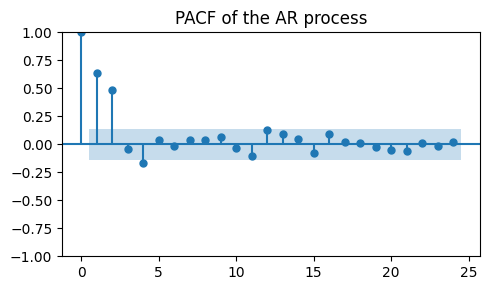

In [13]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))

plot_pacf(ar_data, ax=ax, title="PACF of the AR process")
plt.tight_layout();

- Помимо пика при лаге $0$, который всегда присутствует, мы видим два значимых пика:
- Положительный пик при лаге $1$, вызванный отрицательным коэффициентом $-0.5$.
- Отрицательный пик при лаге $2$, вызванный положительным коэффициентом $0.7$.

- Это означает, что процесс имеет "память" длиной 2.
- Другими словами, (большая часть) корреляций в данных объясняется двумя предыдущими временными шагами.
- Если мы хотим подобрать модель AR для наших данных, мы выберем $p=2$, то есть модель AR(2).
- Наконец, процесс AR характеризуется корреляциями, которые медленно убывают со временем.
- Это можно увидеть  на графике автокорреляционной функции (ACF), где наблюдаются значимые пики на протяжении многих лагов.


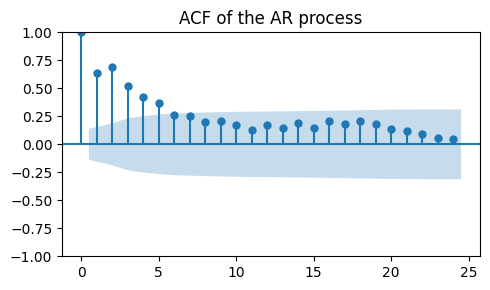

In [14]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ar_data, ax=ax, title="ACF of the AR process")
plt.tight_layout()

**⚙ Попробуйте самостоятельно**

- Поэкспериментируйте с изменением, добавлением или удалением значений коэффициентов `ar` в функции `arma_generate_sample`.
- Затем посмотрите, как изменится график частичной автокорреляционной функции (PACF).

### Прогнозирование с использованием моделей AR
- Как вычислять прогнозы с помощью модели AR?
- В общем случае наш временной ряд имеет тренд и сезонность.
- Однако модель AR можно использовать только для *стационарных данных*.
- Поэтому нам необходимо выполнить следующие шаги:

#### Шаг 1 Удаление тренда и сезонности

- Перед применением модели AR необходимо сделать временной ряд стационарным.
- Это можно сделать с помощью методов, которые мы рассматривали в предыдущих заданиях.
- Есть два возможных способа:
  1. Применить стандартное и сезонное дифференцированиек временному ряду:
     $$
     R'(t) = X(t + 1) - X(t) \qquad \text{removes trend}
     $$
     $$
     R(t) = R'(t + 1) - R'(t)  \qquad \text{removes seasonality}
     $$
  2. Оценить тренд $T$ и сезонность $S$ (например, с помощью сезонной декомпозиции или методов сглаживания) и вычесть их:
        $$R(t) = X(t) - T(t) - S(t)$$

#### Шаг 2: Применение AR модели

- Определите порядок AR модели.
- Обучите AR модель для временного ряда $R(t)$, в котором исклучены тренд и сезонность.
- Используйте обученную модель для прогнозирования значений $\hat R(t+\tau), \tau=1, \dots, H$ где $H$ горизонт прогнозирования.

#### Шаг 3: Реконструкция прогноза

- Процедура реконструкции зависит от того каким образом мы сделали ряд стационарным на шаге 1.
- Если мы использовали дифференцирование:
    - Мы должны отменить дифференцирование, взяв кумулятивные суммы остатков.
- Если мы удаляли тренд и сезонность, то для каждого $\tau \in [1, H]$:
    - Предскажите  тренд $\hat{T}(t+\tau)$ и сезонную составляющую $\hat{S}(t+\tau)$.
    - И добавьте предсказанный тренд и сезонность к спрогнозированному значению:

    $$\hat X(t+\tau) = \hat R(t+\tau) + \hat{T}(t+\tau) + \hat{S}(t+\tau)$$


### Пример: прогнозирование с использованием AR модели

- Давайте сгенерируем данные, имеющие тренд и сезонность.

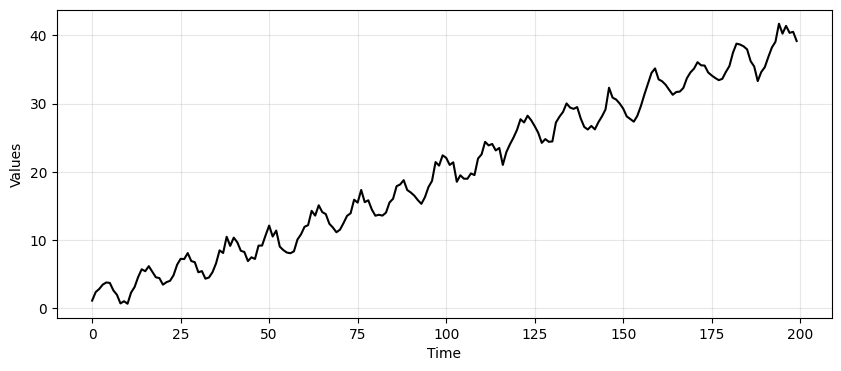

In [15]:
time = np.arange(200)
trend = time * 0.2
seasonality = 2*np.sin(2*np.pi*time/12) # Seasonality 12
time_series_ar = trend + seasonality + ar_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ar, "", ax=ax);

- Поскольку мы собираемся вычислять прогнозы, давайте разделим данные на обучающий и тестовый наборы.

In [16]:
train_data_ar = time_series_ar[:164]
test_data_ar = time_series_ar[164:]

- Чтобы определить порядок $p$ AR-модели, нам нужно взглянуть на PACF.
- Порядок $p$ соответствует наименьшему ненулевому значимому лагу на графике PACF.

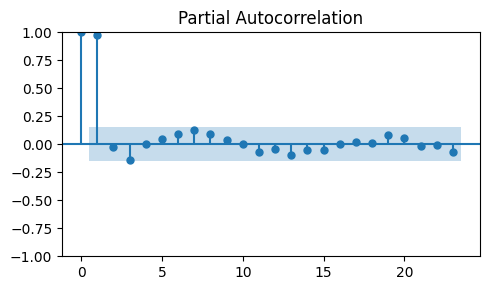

In [17]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(train_data_ar, ax=ax)
plt.tight_layout();

- Исходя из графика PACF можно было бы предложить порядок $p=1$.
- Однако, этот график PACF *не имеет особого смыла*.
- Как мы уже обсуждали ранее, обе корреляционные функции ACF и PACF следует вычислять на основе стационарных данных.
- Если данные стационарны, корреляции быстро снижаются.
- Если быстрого снижения не происходит, это признак того что Ваши данные не являются стационарными.

- Поскольку мы генерировали временной ряд вручную мы знаем, что он имеет тренд и сезонность, и, следовательно, не является стационарным.
- Однако, для большей строгости мы проверим на временной ряд с помощью расширенного теста Дики-Фуллера (ADF-test).

In [18]:
_, pvalue, _, _, _, _ = adfuller(train_data_ar)
print(f"p-value: {pvalue:.3f}")

p-value: 0.987


- Такое высокое значение p-value означает, что нам  *не удалось* отвергнуть нулевую гипотезу.

 $$H_0: \text{данные нестационарны}$$

- Здесь никаких сюрпризов нет.

- Чтобы добиться стационарности, мы можем преобразовать данные, применив один из методов, обсуждаемых в [шаге 1](#Шаг-1-Удаление-тренда-и-сезонности).
- Давайте сначала попробуем использовать дифференцирование.

#### Стационарность через дифференцирование

- Мы начнем с дифференцирования 1-го порядка чтобы удалить тренд.
- Затем мы проверим стационарность полученных данных с помощью ADF теста.

In [19]:
diff_ar = train_data_ar[1:] - train_data_ar[:-1]

_, pvalue, _, _, _, _ = adfuller(diff_ar)
print(f"p-value: {pvalue:.3f}")

p-value: 0.000


- ADF тест предполагает, что теперь временной ряд стационарен.
- Мы могли бы так же применить дифференцирование 2-го порядка, чтобы избавиться от сезонной составляющей.
- Однако, слишком частое вычисление разностей может привести к нарушению структуры данных.
- Эта проблема называется  *чрезмерное дифференцирование*.
- См. [это объяснение](https://people.duke.edu/~rnau/411arim2.htm) для определения оптимального порядка дифференцирования.

- Давайте посмотрим как будут выглядеть данные после дифференцирования первого порядка.

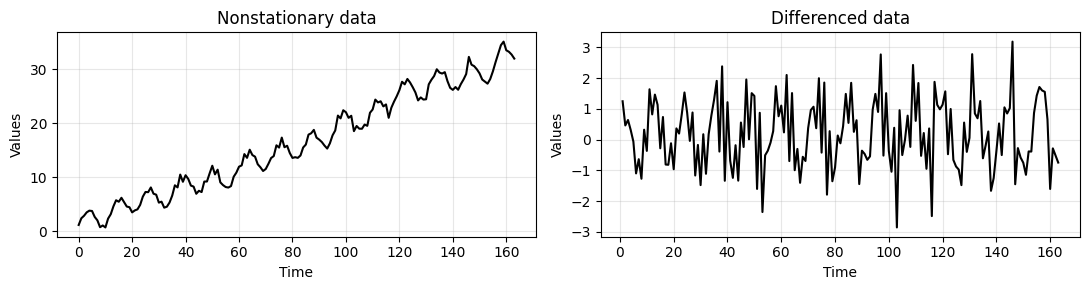

In [20]:
_, axes = plt.subplots(1,2, figsize=(11,3))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, title="Nonstationary data", ax=axes[0])
run_sequence_plot(time[1:len(train_data_ar)], diff_ar, title="Differenced data", ax=axes[1])
plt.tight_layout();

- Давайте пересчитаем PACF на основе полученных разностных данныз.
- Мы также сравним его PACF, рассчитанным на исходных `ar_data` н нестационарных данных `train_data_ar`.

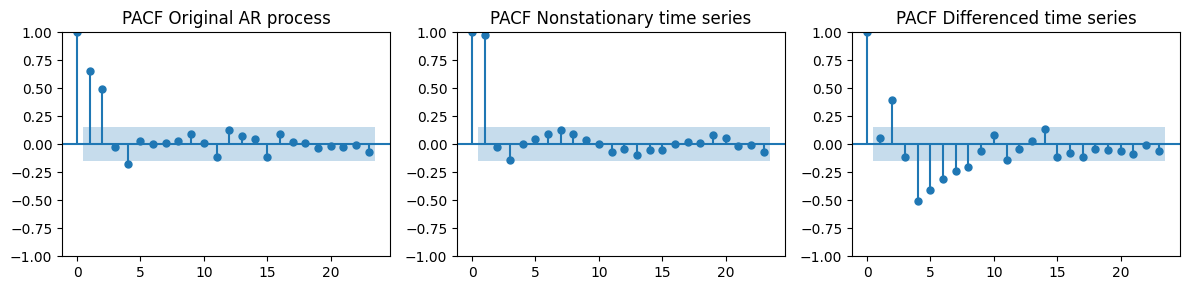

In [21]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(train_data_ar, ax=axes[1], title="PACF Nonstationary time series")
plot_pacf(diff_ar, ax=axes[2], title="PACF Differenced time series")
plt.tight_layout();

- Заметный отрицательный всплеск при лаге 2 проявляется как в PACF исходных данных AR, так и в дифференцированных временных рядах.
- Эти два графика  выглядят более похожими, чем PACF, который мы получили для нестационарных данных.
- Заметный всплеск при лаге 2 предполагает, что $p=2$, т.е. мы должны использовать модель AR(2).

**⚠ Внимание**

- В дифференцированных временных рядах также наблюдаются другие значительные всплески с большими лагами, которых нет в исходных данных AR.
- Это связано с тем, что в данных осталась сезонная составляющая.
- Давайте посмотрим, сможем ли мы устранить их, применив сезонное дифференцирование , и пересчитаем график PACF.

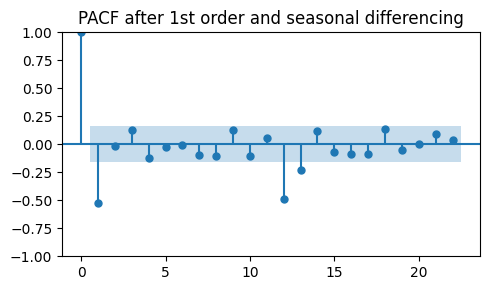

In [22]:
# Seasonal differencing
diff_diff_ar = diff_ar[12:] - diff_ar[:-12]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(diff_diff_ar, ax=ax, title="PACF after 1st order and seasonal differencing")
plt.tight_layout();

- Даже после учета сезонных различий мы не можем восстановить PACF исходных данных.
- Напротив, этот PACF выглядит еще более отличным от исходного.
- На практике редко удается получить "чистый" PACF с единственным заметным отставанием в правильном порядке при использовании дифференцирования.
- Интерпретация графиков PACF (и ACF) для выбора порядка построения модели требует навыков и опыта.
- Смотрите [это объяснение](https://people.duke.edu/~rnau/411arim3.htm), чтобы узнать, как выбрать порядок моделей AR и MA.

**📝 Примечание**

- Помимо чрезмерного дифференцирования, возникают другие проблемы, если получать стационарность с помощью дифференцирования.
- Некоторые данные теряются в начале или в конце временного ряда из-за дифференцирования.
    - Например, после применения дифференцирования первого порядка и сезонного дифференцирования первые $L+1$ значений данных теряются.
- Кроме того, легко допустить ошибки при восстановлении данных при формировании прогнозов.
- Ситуация еще больше осложняется если существет разрыв между тренировочными и тестовыми данными или когда горизонт прогноза $H$ выходит за рамки сезонности $L$.

#### Стационарность путем вычитания предполагаемого тренда и сезонности

- Мы могли бы оценить тренд и сезонность с помощью тройного экспоненциального сглаживания (TES).
- Затем мы вычисляем остатки, вычитая предполагаемый тренд и сезонность.
- Мы видим, что в данном случае, намного ближе к нашим первоначальным данным.

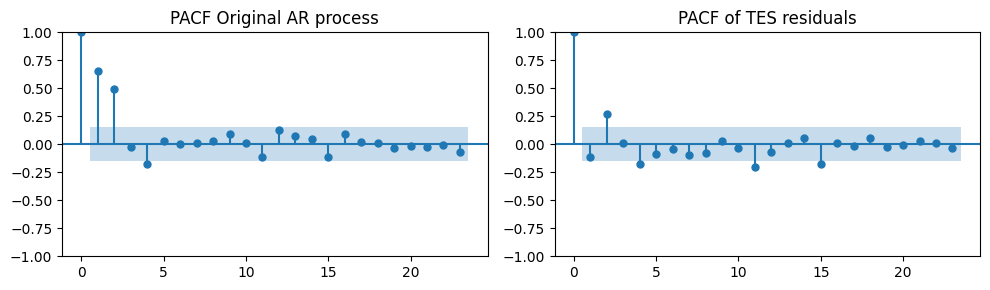

In [23]:
tes = ExponentialSmoothing(train_data_ar, trend='add',
                           seasonal='add', seasonal_periods=12).fit()
trend_and_seasonality = tes.fittedvalues # Estimated trend and seasonality
tes_resid = train_data_ar - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(tes_resid, ax=axes[1], title="PACF of TES residuals")
plt.tight_layout();

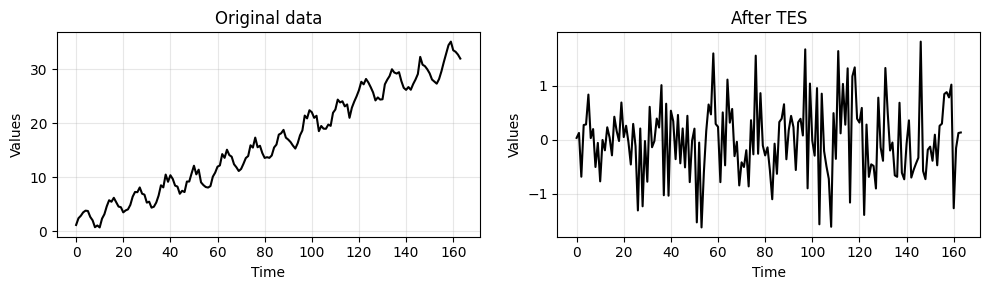

In [24]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, title="Original data", ax=ax[0])
run_sequence_plot(time[:len(train_data_ar)], tes_resid, title="After TES", ax=ax[1])
plt.tight_layout()

**💡 Подсказка**

- В данном случае мы знали, что основной период равен `12`.
- В общем случае, нам нужно его оценить.
- Мы можем использовать функцию `fft_analysis` функцию из `Задания 1`.

In [25]:
from scipy.fft import fft

In [26]:
def fft_analysis(signal):

    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept
    detrended = signal - trend

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")

    return dominant_period, positive_frequencies, magnitudes

In [27]:
period, _, _ =fft_analysis(time_series_ar)
print(f"Period: {np.round(period)}")

Dominant Frequency: 0.085
Dominant Period: 11.76 time units
Period: 12.0


**⚠ Внимание**

- Сглаживание здесь работает так хорошо, потому что мы используем игрушечные данные с аддитивными компонентами, линейным трендом, постоянной дисперсией и т.д...
- Многие реальные данные выглядят не так привлекательно.
- В некоторых случаях нам приходится полагаться на другие методы, включая дифференциацию и "грязный" график ACF/PACF, который мы получили на его основе.

### Прогнозирование с помощью AR-модели

- Как только данные стали стационарными, мы готовы использовать модель AR(2).
- В зависимости от того, какой метод мы использовали для получения стационарных данных, мы должны будем делать различные действия, чтобы восстановить прогнозы.
- Давайте начнем со стационарных данных, полученных с помощью дифференцирования.

**Использование дифференцирования**

- Сначала мы используем `diff_diff_ar` чтобы обучить AR(2)-модель и сделать  прогнозы на период, равный продолжительности тестовых данных.
- Обратите внимание, что через некоторое время прогноз обнуляется.
- Это указывает на то, что модель AR(2) очень неопределённа в отношении долгосрочных прогнозов.

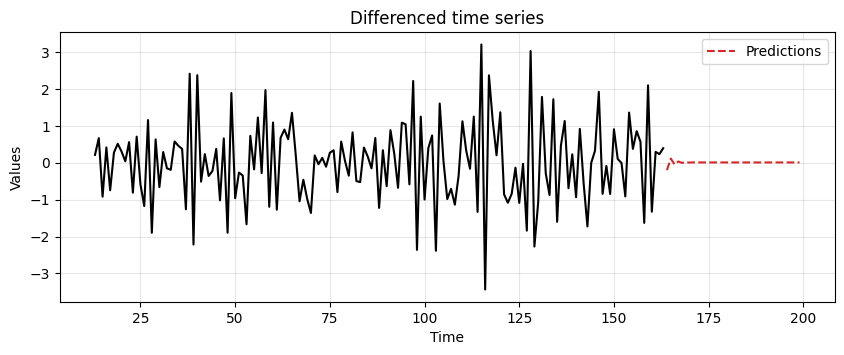

In [28]:
# Fit the model
model = ARIMA(diff_diff_ar, order=(2,0,0))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[13:len(train_data_ar)], diff_diff_ar, "")
ax.plot(time[len(train_data_ar):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

- Чтобы получить окончательные прогнозы, мы должны сначала вернуть сезонную разницу, а затем разницу 1-го порядка.

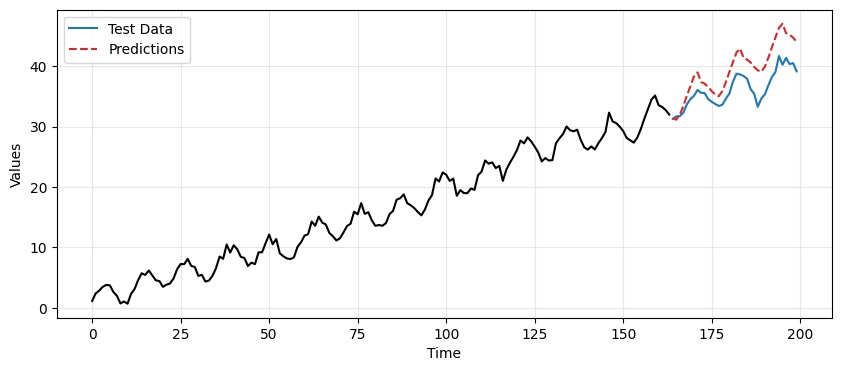

In [29]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ar))
reintegrated_seasonal[:12] = diff_ar[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ar)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated = reintegrated_seasonal.cumsum() + train_data_ar[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], reintegrated, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

**⚠ Внимание**

- Очень легко допустить ошибки с индексами при обратном применении операции дифференцирования.
- Кроме того, предыдущие операции предполагают, что между обучающими и тестовыми данными нет разрывов.

**Подход на основе TES**

- Далее мы рассматриваем стационарные данные, полученные путем вычитания тренда и сезонности, оцененных с помощью тройного экспоненциального сглаживания (TES).
- В этот раз мы используем `tes_resid` для обучения AR(2)-модели и построения прогнозов.

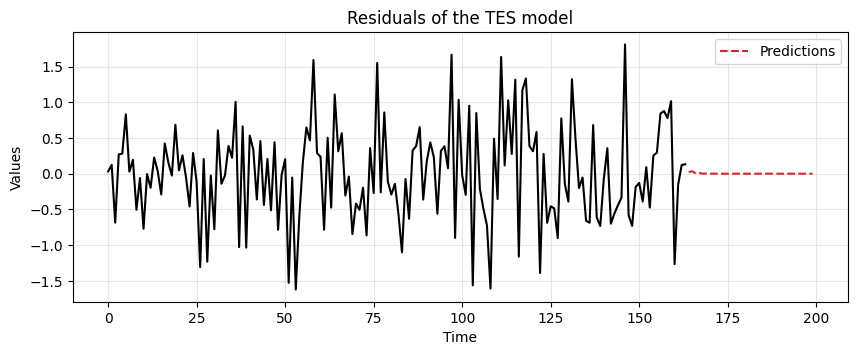

In [30]:
model = ARIMA(tes_resid, order=(2,0,0))
model_fit = model.fit()

resid_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[:len(train_data_ar)], tes_resid, "")
ax.plot(time[len(train_data_ar):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- Затем мы добавляем обратно тренд и сезонность к предсказаниям.
- Для этого мы сначала генерируем прогнозы для трендовой и сезонной составляющих с помощью TES.
- Наконец, мы суммируем все предсказания, чтобы получить окончательный результат.

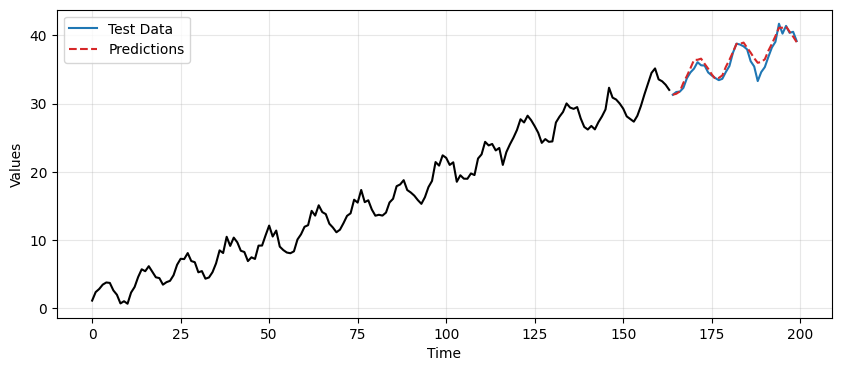

In [31]:
# Add back trend and seasonality to the predictions
tes_pred = tes.forecast(len(test_data_ar))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- Используя подход на основе TES, мы получаем более точные предсказания по сравнению с дифференцированием.
- Мы можем количественно оценить разницу в качестве предсказаний вычислив MSE (среднеквадратичную ошибку).

In [32]:
mse_differencing = mean_squared_error(test_data_ar, reintegrated)
mse_tes = mean_squared_error(test_data_ar, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 13.19
MSE of TES: 0.65


---

## Модели скользящего среднего (MA)

- Другим подходом к моделированию одномерных временных рядов является модель скользящего среднего (MA).
- Модель MA представляет собой линейную регрессию текущего значения ряда на белый шум от одного или нескольких предыдущих значений ряда.
- Шум в каждой точке предполагается нормально распределенным с математическим ожиданием 0 и постоянной дисперсией.

- Модель MA определяется следующим уравнением:

$$X(t) = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}$$

- где:
    - $X(t)$: значение временного ряда в момент времени $t$.
    - $\mu$: среднее значение ряда.
    - $\theta_1, \theta_2, \dots, \theta_q$: коэффициенты модели.
    - $q$: порядок модели MA (число запаздывающих ошибок).
    - $\epsilon_t$: ошибка (белый шум) в момент времени $t$.

- Модели MA захватывают зависимость между наблюдением и остаточной ошибкой с помощью скользящего среднего, применяемого к запаздывающим наблюдениям.
- Обучение MA-модели более сложно, чем для моделей AR, поскольку ошибки не наблюдаемы.
- Поэтому необходимо использовать итеративные нелинейные процедуры во время обучения.
- Модели MA менее интерпретируемы, чем модели AR.
- Как и модели AR, модели MA требуют, чтобы данные были стационарными.

**⚠ Внимание**
- Мы говорили о сглаживании с помощью скользящих средних в `Задании 3`.
- Модели MA не являются теми же самыми техниками сглаживания.
- Каждая из них выполняет различные, важные функции.
- Нам не следует путать их.

### Идентификация модели MA

- Ранее, в разделе `Определение порядка модели  AR` мы выбирали к качестве $p$ лаг, после которого пики в PACF становятся незначимыми.
- Для идентификации порядка $q$ модели MA мы делаем то же самое, но используем график ACF.
- Давайте рассмотрим это на примере

- Мы генерируем данные из процесса MA(2) с коэффициентами `[1.0, 0.7, 0.8]`.
- Снова, значение `1.0` в начале относится к нулевому лагу.

In [33]:
ma = np.array([1.0, 0.7, 0.8])  # MA parameters
ma_data = arma_generate_sample(np.array([1]), ma, nsample=len(time), scale=1, burnin=1000) # MA process

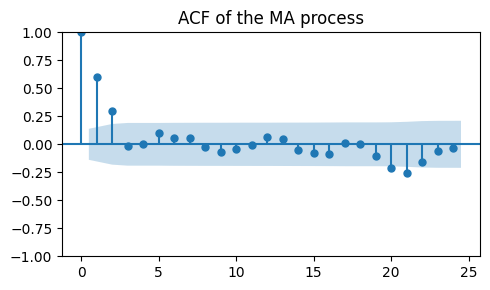

In [34]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ma_data, ax=ax, title="ACF of the MA process")
plt.tight_layout();

- Как и ожидалось, после второго лага происходит обрезание.
- то означает, что порядок модели скользящего среднего (MA) равен $q=2$.

- Характеристика процесса MA — это медленно убывающие, чередующиеся пики на графике PACF.
- Обратите внимание, как это дополняет то, что мы видели для процесса AR.

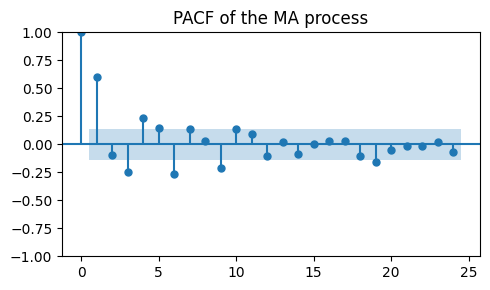

In [35]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(ma_data, ax=ax, title="PACF of the MA process")
plt.tight_layout();

**⚙ Попробуйте сами**

- Попробуйте изменить/добавить/удалить значения в коэффициентах `ma` в функции `arma_generate_sample`.
- Затем посмотрите, как изменится график ACF.

### Пример: прогнозирование с моделью MA

- Мы повторяем ту же процедуру, что и в примере с `AR моделью`, но теперь используем `модель MA`.
- Единственное отличие заключается в том, что мы строим временной ряд, используя процесс MA, а не AR.

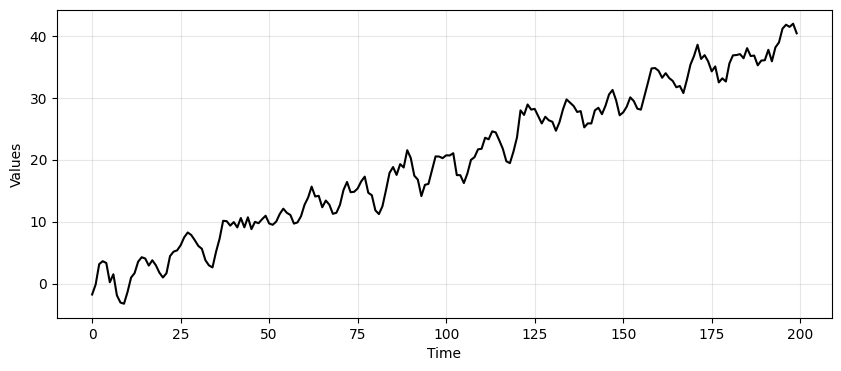

In [36]:
time_series_ma = trend + seasonality + ma_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ma, "", ax=ax);

In [37]:
# Train/test split
train_data_ma = time_series_ma[:164]
test_data_ma = time_series_ma[164:]

- Чтобы определить порядок $q$ модели MA, нужно посмотреть на график ACF.
- Давайте начнем с вычисления ACF для `train_data_ma`, который выглядит совсем по-другому по сравнению с графиком ACF, который мы получили ранее для процесса MA.

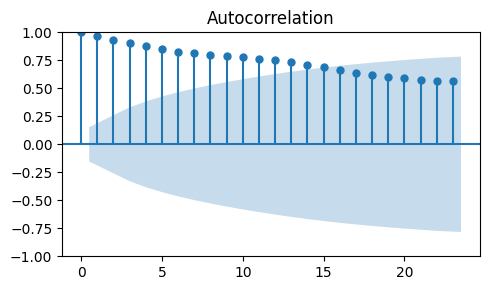

In [38]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(train_data_ma, ax=ax)
plt.tight_layout();

- В этом случае нам точно также нужно сделать временной ряд стационарным, чтобы получить осмысленный график ACF.
- Как и в случае с AR, стационарность необходима для правильной оценки коэффициентов MA.

#### Стационарность через дифференцирование

- Как и в примере с AR, мы попробуем добиться стационарности через дифференцирование.


In [39]:
diff_ma = train_data_ma[1:] - train_data_ma[:-1]

- Чтобы убедиться, что наши данные стационарны, мы вычислим тест ADF до и после дифференцирования.

In [40]:
_, pvalue_ts, _, _, _, _ = adfuller(train_data_ma)
_, pvalue_diff, _, _, _, _ = adfuller(diff_ma)
print(f"p-value (original ts): {pvalue_ts:.3f}")
print(f"p-value (differenced ts): {pvalue_diff:.3f}")

p-value (original ts): 0.925
p-value (differenced ts): 0.000


- Мы также строим график дифференцированных данных и вычисляем ACF.

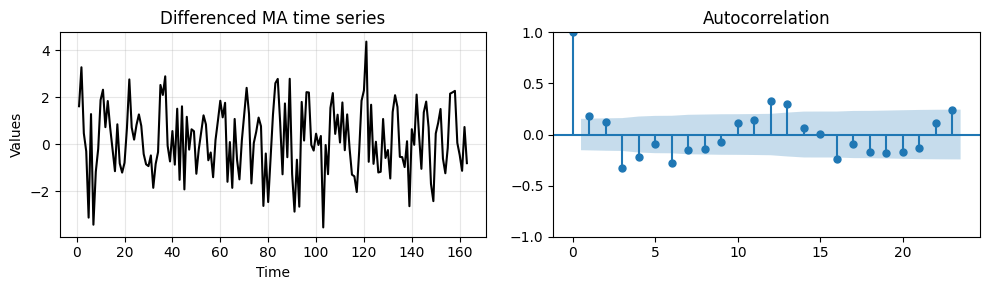

In [41]:
_, axes = plt.subplots(1,2, figsize=(10, 3))
run_sequence_plot(time[1:len(train_data_ma)], diff_ma, "Differenced MA time series", ax=axes[0])
plot_acf(diff_ma, ax=axes[1])
plt.tight_layout();

- Как и в предыдущем случае, у нас есть значительные корреляции на больших лагах из-за сезонного компонента.
- Для сравнения, мы вычисляем ACF для::
    - исходного процесса MA,
    - временного ряда после дифференцирования 1-го порядка,
    - временного ряда после дифференцирования 1-го порядка и сезонного дифференцирования.

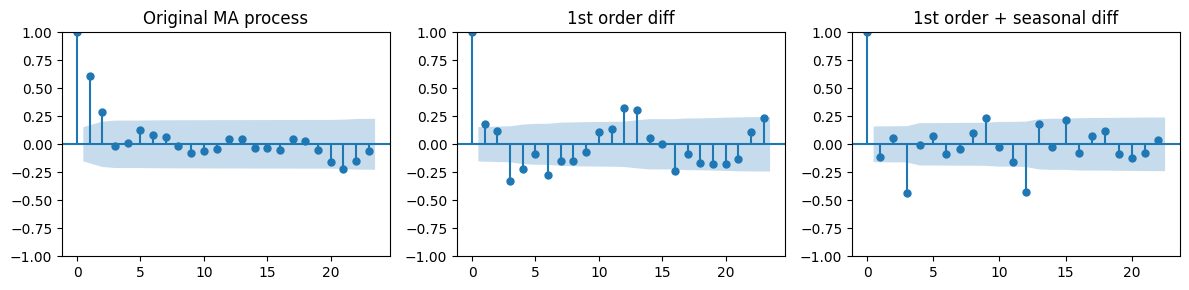

In [42]:
diff_diff_ma = diff_ma[12:] - diff_ma[:-12]

_, axes = plt.subplots(1,3, figsize=(12, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="Original MA process")
plot_acf(diff_ma, ax=axes[1], title="1st order diff")
plot_acf(diff_diff_ma, ax=axes[2], title="1st order + seasonal diff")
plt.tight_layout();

- После обоих видов дифференцирования график ACF выглядит совершенно иначе.
- Положительные корреляции на лагах 1 и 2 исчезают, а первая ненулевая корреляция появляется на лаге 3.
- Как мы видели в случае с AR, это может свидетельствовать о чрезмерном дифференцировании.

- В итоге, не очевидно, какую модель MA использовать на основе анализа графиков ACF.
- ACF после дифференцирования первого порядка предполагает использование порядка $q=1$ или $q=2$.
- ACF, полученный после сезонного дифференцирования, предполагает порядок $q=3$, , но мы подозреваем чрезмерное дифференцирование.

#### Стационарность путем вычитания оцененного тренда и сезонности

- В дальнейшем мы повторяем ту же процедуру для оценки тренда и сезонности с использованием TES.
- Поскольку процесс MA более "шумный", чем процесс AR, мы увеличиваем уровень сглаживания, установив $\alpha=0.01$.
- Как показано на графике ниже, это приводит к более гладкой оценке тренда и сезонности.

Dominant Frequency: 0.085
Dominant Period: 11.76 time units


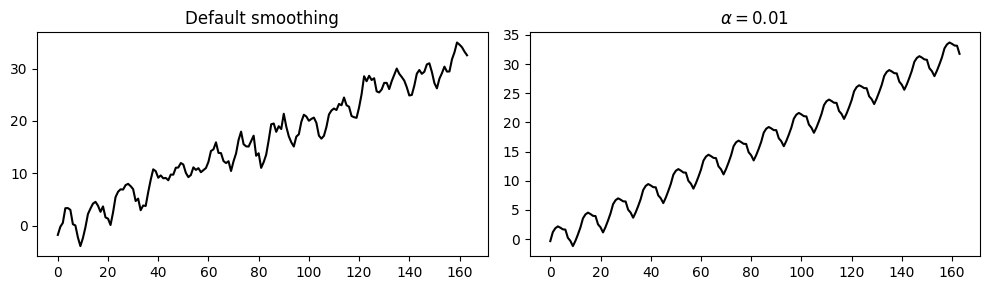

In [43]:
period, _, _ =fft_analysis(time_series_ma)
period = np.round(period).astype(int)

tes_ma_default = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=None)
tes_ma = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=0.01)
trend_and_seasonality_default = tes_ma_default.fittedvalues
trend_and_seasonality = tes_ma.fittedvalues

_, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(trend_and_seasonality_default, 'k')
axes[0].set_title('Default smoothing')
axes[1].plot(trend_and_seasonality, 'k')
axes[1].set_title('$\\alpha=0.01$')
plt.tight_layout();

- Далее мы вычисляем остатки, вычитая оцененные тренд и сезонность.
- Графики ACF для исходного процесса MA и остатков очень похожи.
- Это указывает на то, что мы корректно удалили тренд и сезонность.

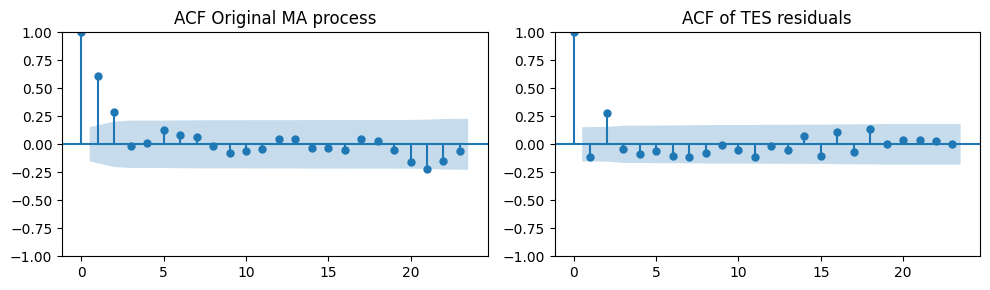

In [44]:
tes_resid_ma = train_data_ma - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="ACF Original MA process")
plot_acf(tes_resid, ax=axes[1], title="ACF of TES residuals")
plt.tight_layout();

- График ACF показывает значительный всплеск на лаге 3.
- Это предполагает использование модели MA порядка $q=3$.
- Как и в случае с AR, мы вычисляем прогнозы, используя как метод дифференцирования, так и подход на основе TES.

**Подход с дифференцированием**

- Сначала мы обучаем модель MA на данных `diff_diff_ma` и вычисляем прогнозы.
- Заметьте, что, хотя данные были сгенерированы с процессом MA(2), мы используем процесс MA(3), так как на графике ACF `diff_diff_ma` был значительный всплеск на лаге 3.

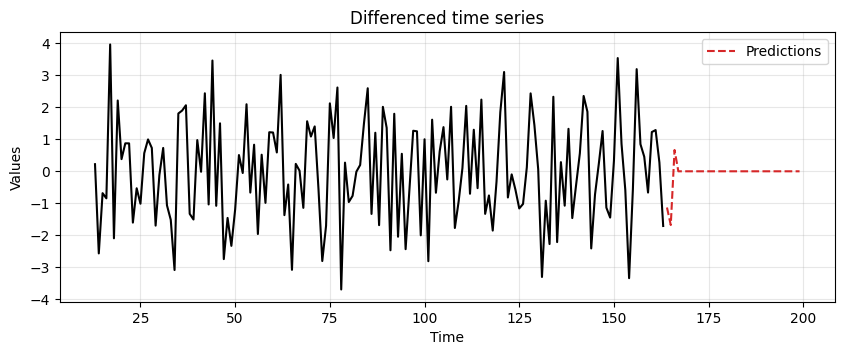

In [45]:
# Fit the model
model = ARIMA(diff_diff_ma, order=(0,0,3))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ma))

ax = run_sequence_plot(time[13:len(train_data_ma)], diff_diff_ma, "")
ax.plot(time[len(train_data_ma):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

- Затем мы обращаем обе операции дифференцирования, чтобы получить окончательные прогнозы.

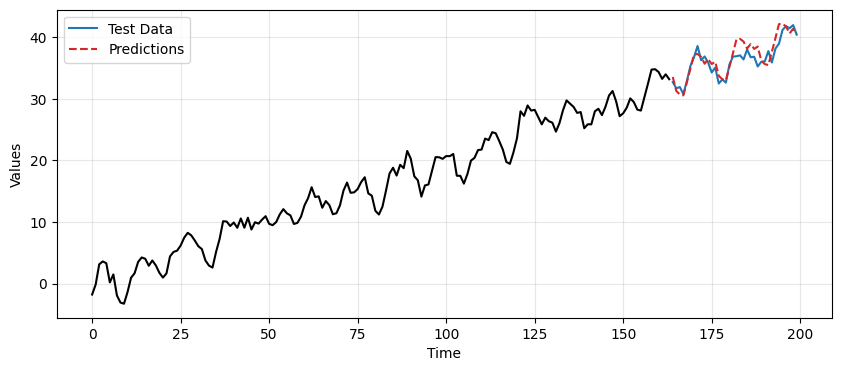

In [46]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ma))
reintegrated_seasonal[:12] = diff_ma[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ma)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated = reintegrated_seasonal.cumsum() + train_data_ma[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], reintegrated, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

**Подход на основе TES**

- В этот раз мы обучаем MA-модель на данных `tes_resid_ma` и вычисляем прогнозы.
- Заметьте, что снова используется модель MA(3), даже несмотря на то, что данные были сгенерированы процессом MA(2).

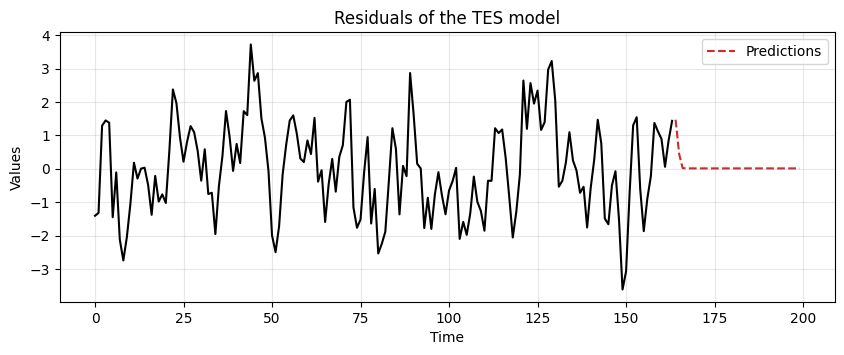

In [47]:
model = ARIMA(tes_resid_ma, order=(0,0,3))
model_fit = model.fit() # Fit the model

resid_preds = model_fit.forecast(steps=len(test_data_ma)) # Compute predictions

ax = run_sequence_plot(time[:len(train_data_ma)], tes_resid_ma, "")
ax.plot(time[len(train_data_ma):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- Окончательные прогнозы получаются путем объединения:
    - прогнозов остатков из модели MA,
    - прогноза тренда и сезонности из модели TES.

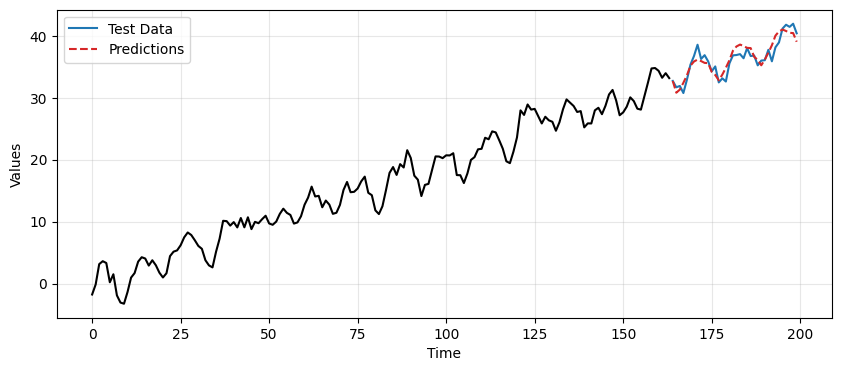

In [48]:
# Add back trend and seasonality to the predictions
tes_pred = tes_ma.forecast(len(test_data_ma))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- На этот раз метод дифференцирования дает лучшие результаты, но все же уступает подходу на основе TES.

In [49]:
mse_differencing = mean_squared_error(test_data_ma, reintegrated)
mse_tes = mean_squared_error(test_data_ma, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 2.08
MSE of TES: 1.44


---

## Итог

### AR vs MA модели

| **AR-модели** | **MA-модели** |
|:--------------|:--------------|
|Зависит от прошлых значений ряда. | Зависит от прошлых ошибок прогноза. |
| Подходят, когда прошлые значения напрямую влияют на будущие и для медленно изменяющихся временных рядов. | Полезны, когда ряд лучше объясняется случайными шоками или возмущениями, то есть для рядов с резкими изменениями.|
| Если **PACF** резко обрывается на лаге $p$, используйте **AR**-модель порядка $p$.| Если **ACF** резко обрывается на лаге $q$, используйте **MA**-модель порядка $q$. |

В этом занятии вы должны были изучить основы:

1. Функции автокорреляции (ACF).
2. Частичной автокорреляционной функции (PACF).
3. Авторегрессионных (AR) моделей.
4. Выбора порядка $p$.
5. Моделей скользящего среднего (MA).
6. Выбора порядка $q$.
7. Комбинирования методов сглаживания для прогнозирования тренда и сезонности с моделями AR/MA для предсказания остатков.

---

## Упражнения

- Загрузите два временных ряда `arma_ts1` и `arma_ts2` , выполнив следующий код.

In [50]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts3.npz?download=1")
response.raise_for_status()
arma_ts1 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts4.npz?download=1")
response.raise_for_status()
arma_ts2 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts2))

479
1000


Для каждого временного ряда:

1. Разделите временной ряд на обучающую и тестовую выборки.
    - Используйте последние 30 значений в качестве тестовой выборки для первого ряда.
    - Используйте последние 100 значений в качестве тестовой выборки для второго ряда.

In [51]:
train_ts1 = arma_ts1[:-30]
test_ts1 = arma_ts1[-30:]
time1 = np.arange(len(train_ts1))
time11 = np.arange(len(train_ts1)+len(test_ts1))

In [52]:
train_ts2 = arma_ts2[:-100]
test_ts2 = arma_ts2[-100:]
time2 = np.arange(len(train_ts2))
time22 = np.arange(len(train_ts2)+len(test_ts2))

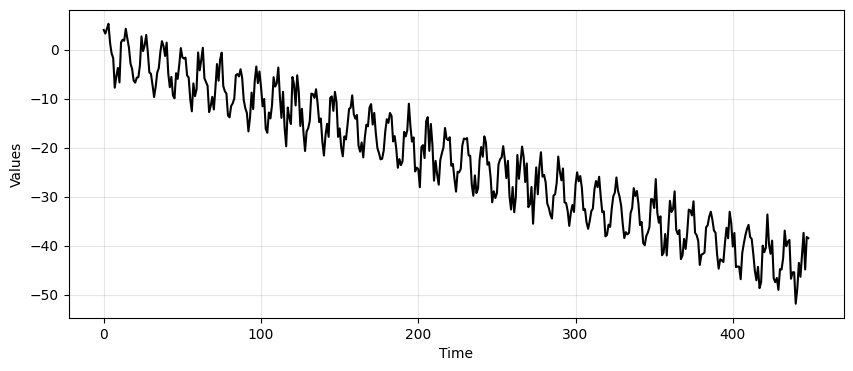

In [53]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time1, train_ts1, "", ax=ax);

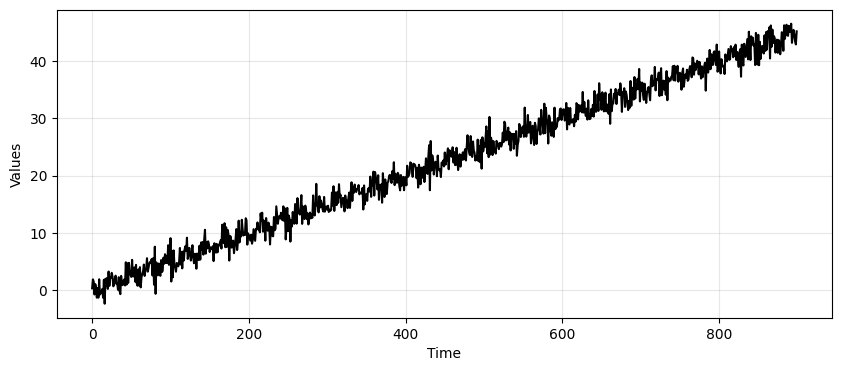

In [54]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time2, train_ts2, "", ax=ax);

2. Сделайте временной ряд стационарным.

3. Определите порядок $p$ для AR-модели.

Стационарность путем вычитания предполагаемого тренда и сезонности

ts1

In [55]:
_, pvalue, _, _, _, _ = adfuller(train_ts1)
print(f"p-value: {pvalue:.3f}")

p-value: 0.933


In [56]:
period, _, _ =fft_analysis(train_ts1)
print(f"Period: {np.round(period)}")

Dominant Frequency: 0.082
Dominant Period: 12.14 time units
Period: 12.0


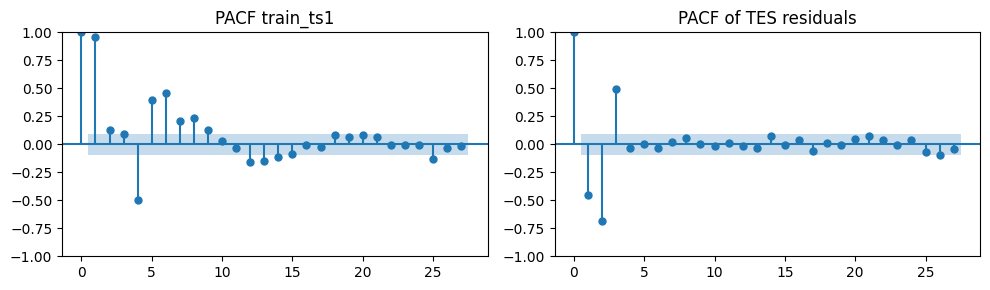

In [73]:
tes_ts1 = ExponentialSmoothing(train_ts1, trend='add',
                           seasonal='add', seasonal_periods=12).fit()
trend_and_seasonality_ts1 = tes_ts1.fittedvalues # Estimated trend and seasonality
tes_resid_ts1 = train_ts1 - trend_and_seasonality_ts1

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_pacf(train_ts1, ax=axes[0], title="PACF train_ts1")
plot_pacf(tes_resid_ts1, ax=axes[1], title="PACF of TES residuals")
plt.tight_layout();

In [68]:
_, pvalue, _, _, _, _ = adfuller(tes_resid_ts1)
print(f"p-value: {pvalue:.3f}")

p-value: 0.000


 $p$=4 для AR-модели ts1

ts2

In [59]:
period, _, _ =fft_analysis(train_ts2)
print(f"Period: {np.round(period)}")

Dominant Frequency: 0.042
Dominant Period: 23.68 time units
Period: 24.0


In [60]:
_, pvalue, _, _, _, _ = adfuller(train_ts2)
print(f"p-value: {pvalue:.3f}")

p-value: 0.947


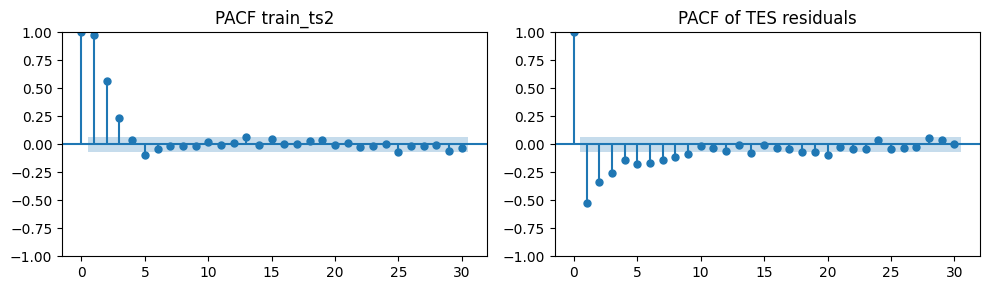

In [72]:
tes_ts2 = ExponentialSmoothing(train_ts2, trend='add',
                           seasonal='add', seasonal_periods=24).fit()
trend_and_seasonality_ts2 = tes_ts2.fittedvalues # Estimated trend and seasonality
tes_resid_ts2 = train_ts2 - trend_and_seasonality_ts2

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_pacf(train_ts2, ax=axes[0], title="PACF train_ts2")
plot_pacf(tes_resid_ts2, ax=axes[1], title="PACF of TES residuals")
plt.tight_layout();

In [71]:
_, pvalue, _, _, _, _ = adfuller(tes_resid_ts2)
print(f"p-value: {pvalue:.3f}")

p-value: 0.000


 $p$=4 для AR-модели ts2

4. Вычислите прогноз для тестовых данных с помощью модели AR($p$).

ts1

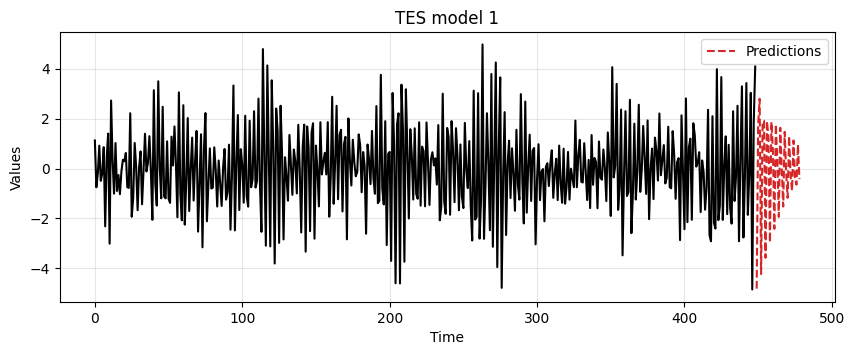

In [77]:
model_ar1 = ARIMA(tes_resid_ts1, order=(4,0,0))
model_fit = model_ar1.fit()

tes_preds_ar1 = model_fit.forecast(steps=len(test_ts1))

ax = run_sequence_plot(time11[:len(train_ts1)], tes_resid_ts1, "")
ax.plot(time11[len(train_ts1):], tes_preds_ar1, label='Predictions', linestyle='--', color='tab:red')
plt.title('TES model 1')
plt.legend();

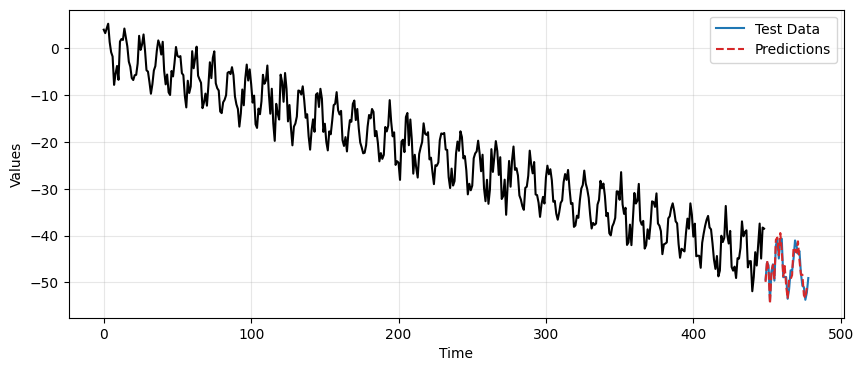

In [79]:
pred_ar1 = tes_ts1.forecast(len(test_ts1))
final_preds_ar1 = pred_ar1 + tes_preds_ar1

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time11[:len(train_ts1)], train_ts1, "", ax=ax)
ax.plot(time11[len(train_ts1):], test_ts1, label='Test Data', color='tab:blue')
ax.plot(time11[len(train_ts1):], final_preds_ar1, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

In [83]:
mse_tes_ar1 = mean_squared_error(test_ts1, final_preds_ar1)

print(f"MSE of TES: {mse_tes_ar1:.2f}")

MSE of TES: 2.22


ts2

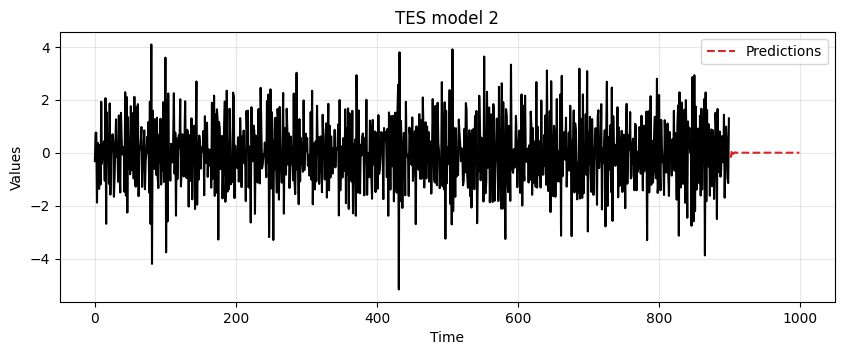

In [81]:
model_ar2 = ARIMA(tes_resid_ts2, order=(4,0,0))
model_fit = model_ar2.fit()

tes_preds_ar2 = model_fit.forecast(steps=len(test_ts2))

ax = run_sequence_plot(time22[:len(train_ts2)], tes_resid_ts2, "")
ax.plot(time22[len(train_ts2):], tes_preds_ar2, label='Predictions', linestyle='--', color='tab:red')
plt.title('TES model 2')
plt.legend();

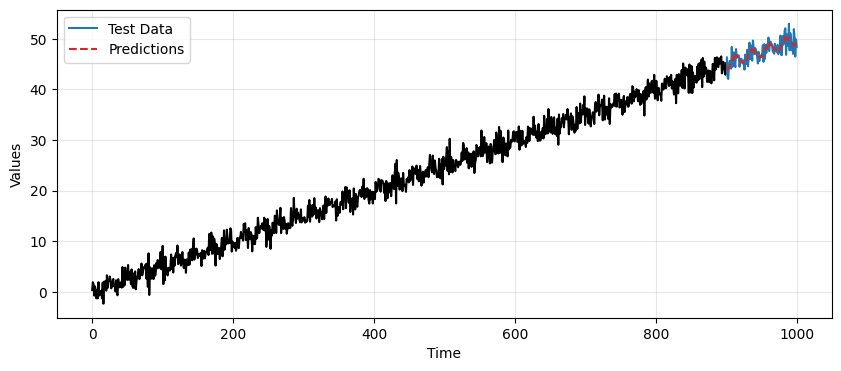

In [82]:
pred_ar2 = tes_ts2.forecast(len(test_ts2))
final_preds_ar2 = pred_ar2 + tes_preds_ar2

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time22[:len(train_ts2)], train_ts2, "", ax=ax)
ax.plot(time22[len(train_ts2):], test_ts2, label='Test Data', color='tab:blue')
ax.plot(time22[len(train_ts2):], final_preds_ar2, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

In [84]:
mse_tes_ar2 = mean_squared_error(test_ts2, final_preds_ar2)

print(f"MSE of TES: {mse_tes_ar2:.2f}")

MSE of TES: 1.68


5. Определите порядок $q$ для MA-модели.

ts1

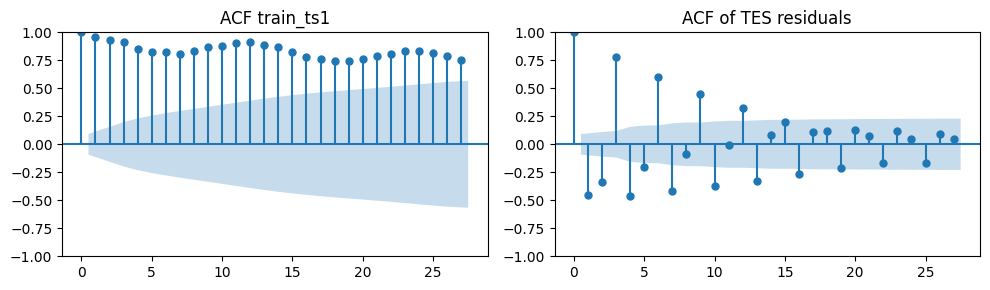

In [85]:
_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_ts1, ax=axes[0], title="ACF train_ts1")
plot_acf(tes_resid_ts1, ax=axes[1], title="ACF of TES residuals")
plt.tight_layout();

 $q$=4 для MA-модели ts2

ts2

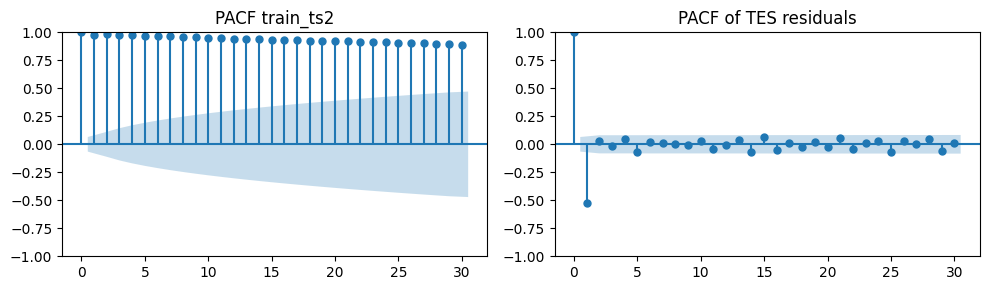

In [87]:
_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_ts2, ax=axes[0], title="PACF train_ts2")
plot_acf(tes_resid_ts2, ax=axes[1], title="PACF of TES residuals")
plt.tight_layout();

 $q$=2 для MA-модели ts2

6. Вычислите прогноз для тестовых данных с помощью модели MA($q$).

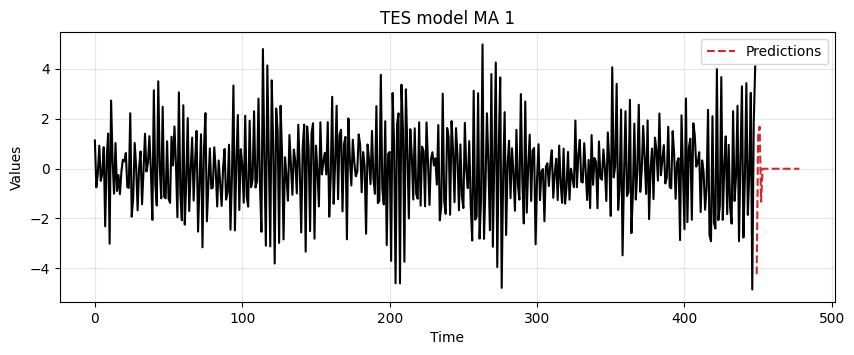

In [92]:
model_ma1 = ARIMA(tes_resid_ts1, order=(0,0,4))
model_fit = model_ma1.fit()

tes_preds_ma1 = model_fit.forecast(steps=len(test_ts1))

ax = run_sequence_plot(time11[:len(train_ts1)], tes_resid_ts1, "")
ax.plot(time11[len(train_ts1):], tes_preds_ma1, label='Predictions', linestyle='--', color='tab:red')
plt.title('TES model MA 1')
plt.legend();

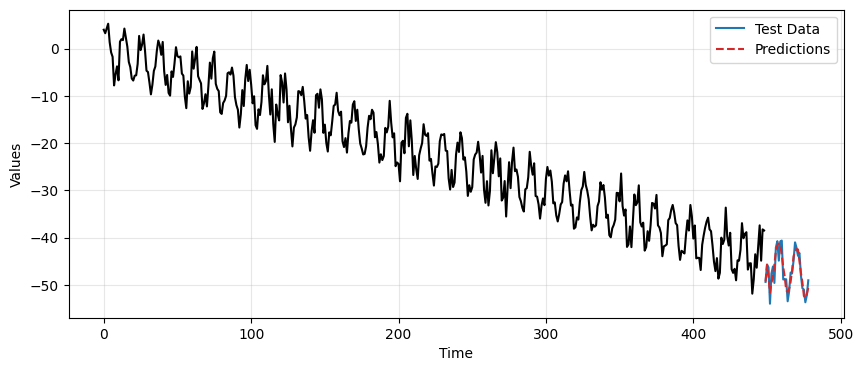

In [93]:
pred_ma1 = tes_ts1.forecast(len(test_ts1))
final_preds_ma1 = pred_ma1 + tes_preds_ma1

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time11[:len(train_ts1)], train_ts1, "", ax=ax)
ax.plot(time11[len(train_ts1):], test_ts1, label='Test Data', color='tab:blue')
ax.plot(time11[len(train_ts1):], final_preds_ma1, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

In [94]:
mse_tes_ma1 = mean_squared_error(test_ts1, final_preds_ma1)

print(f"MSE of TES: {mse_tes_ma1:.2f}")

MSE of TES: 3.14


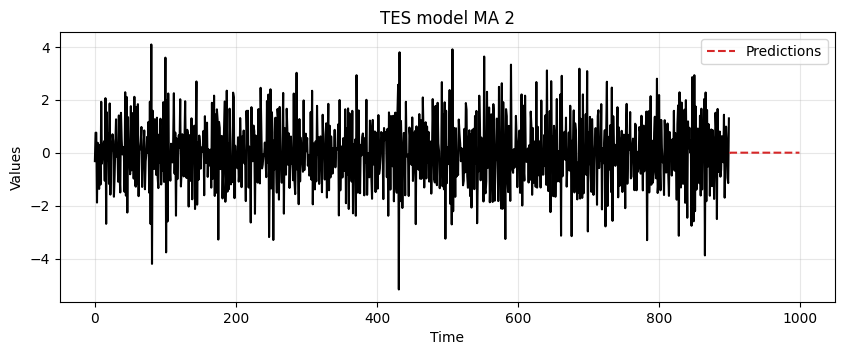

In [95]:
model_ma2 = ARIMA(tes_resid_ts2, order=(0,0,2))
model_fit = model_ma2.fit()

tes_preds_ma2 = model_fit.forecast(steps=len(test_ts2))

ax = run_sequence_plot(time22[:len(train_ts2)], tes_resid_ts2, "")
ax.plot(time22[len(train_ts2):], tes_preds_ma2, label='Predictions', linestyle='--', color='tab:red')
plt.title('TES model MA 2')
plt.legend();

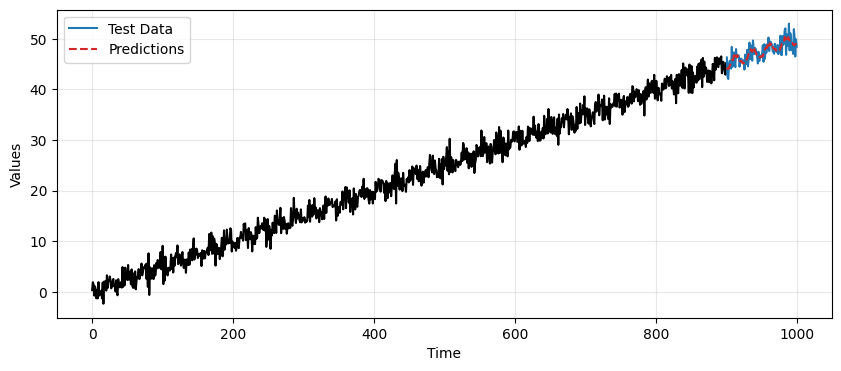

In [96]:
pred_ma2 = tes_ts2.forecast(len(test_ts2))
final_preds_ma2 = pred_ma2 + tes_preds_ma2

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time22[:len(train_ts2)], train_ts2, "", ax=ax)
ax.plot(time22[len(train_ts2):], test_ts2, label='Test Data', color='tab:blue')
ax.plot(time22[len(train_ts2):], final_preds_ma2, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

In [97]:
mse_tes_ma2 = mean_squared_error(test_ts2, final_preds_ma2)

print(f"MSE of TES: {mse_tes_ma2:.2f}")

MSE of TES: 1.69


In [98]:
print(f"MSE of AR 1: {mse_tes_ar1:.2f}")
print(f"MSE of MA 1: {mse_tes_ma1:.2f}")
print(f"MSE of AR 2: {mse_tes_ar2:.2f}")
print(f"MSE of MA 2: {mse_tes_ma2:.2f}")

MSE of AR 1: 2.22
MSE of MA 1: 3.14
MSE of AR 2: 1.68
MSE of MA 2: 1.69
